# Transformer for Language Translation in PyTorch

## Dataset

For the translation task we will use the French-English dataset provided with the zip file. Make sure you extract the zip in the proper location. If the zip file is not extracted in the proper location your code will not work. You'll need to use GPUs (at Google Colab).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Make sure you sure extract the zip in a directory named Transformer. Or change the following depending your directory name

In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Transformer')

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from fra_eng_dataset import FraEngDataset, fra_eng_dataset_collate
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

## Attention Layers

Please read the section "Self-Attention in Detail" in Illustracted Transformer blog post (or see the original paper) and the complete the following section.

In [ ]:
class SelfAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # K V Q are the matrices for creating the keys, values and queries vector
        self.d_model = d_model
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, padding_mask = None, subsq_mask = None):
        # x shape: [N, SEQ, D_MODEL]

        keys = self.K.forward(x)
        values = self.V.forward(x)
        queries = self.Q.forward(x)

        sqrt_d = self.d_model ** 0.5

        att = torch.matmul(queries, keys.transpose(1,2)) / sqrt_d #Attention before softmax comes here
        # att shape: [N, SEQ, SEQ]
        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the sentence
        if padding_mask is not None:
            att = att + padding_mask.transpose(1,2)
        # Add subsequent mask so that each position can attend only itself and the previous elements
        if subsq_mask is not None:
            att = att + subsq_mask.unsqueeze(0)

        att_softmax = torch.softmax(att, dim=2)
        # shape: [N, SEQ, SEQ]
        att_out = torch.matmul(att_softmax, values)
        # shape: [N, SEQ, D_MODEL]

        return att_out, keys, values

### Memory Attention
This is the same as Self Attention only the keys and values matrices are not calculated from weights and input but are passed to the forward function.

In [ ]:
class MemAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, mem_padding_mask, keys = None, values = None):

        # X shape: [N, SEQ, D_MODEL]
        queries = self.Q.forward(x)
        sqrt_d = self.d_model ** 0.5

        att = torch.matmul(queries, keys.transpose(1,2)) / sqrt_d
        # att shape: [N, SEQ_TGT, SEQ_SRC]

        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the source sentence
        if mem_padding_mask is not None:
            att = att + mem_padding_mask.transpose(1,2)

        att_softmax = torch.softmax(att, dim=2)
        # shape: [N, SEQ_TGT, SEQ_SRC]
        att_out = torch.matmul(att_softmax, values)
        # shape: [N, SEQ_TGT, D_MODEL]

        return att_out

### Multi-head attentions for Self Attention and Memory Attention

Please read the section "The Beast With Many Heads" in the illustrated Transformer article before attempting this section

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.heads = nn.ModuleList([SelfAttentionHead(d_model) for i in range(num_heads)]) # Use the nn.ModuleList( ) function for this
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        out_cat = None
        keys = None
        values = None

        for i in range(self.num_heads):
            head_outp, keys, values = self.heads[i].forward(src, src_padding_mask, src_subsq_mask)

            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)

        ret = self.linear.forward(out_cat)

        return ret, keys, values

This is same as before but for memory attention

In [ ]:
class MultiHeadMemAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.heads = nn.ModuleList([MemAttentionHead(d_model) for i in range(num_heads)])
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, keys, values):

        out_cat = None
        for i in range(self.num_heads):
            head_outp = self.heads[i].forward(src, src_padding_mask, keys = keys, values = values)

            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)

        ret = self.linear.forward(out_cat)

        return ret

### Encoder layer

Please read the section "Residuals" in the Illustrated Transformer article before attempting this section

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()

        self.multihead_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.att_sublayer_norm = torch.nn.LayerNorm(d_model) # Use torch.nn.LayerNorm() here

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.relu = nn.ReLU()
        self.dropout_lin = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout2 = nn.Dropout(dropout)
        self.lin_sublayer_norm = torch.nn.LayerNorm(d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        residual_1 = src
        x, keys, values = self.multihead_attention.forward(src, src_padding_mask, src_subsq_mask)
        x = self.att_sublayer_norm.forward(residual_1 + self.dropout1(x)) # call att_sublayer_norm

        residual_2 = x
        x = self.linear2(self.dropout_lin(self.relu(self.linear1.forward(x))))
        x = self.lin_sublayer_norm(residual_2 + self.dropout2(x)) # call lin_sublayer_norm

        return x, keys, values

### Decoder layer

The only difference between Encoder and Decoder layer is the additional MultiHeadMemAttention() sublayer in the decoder layer.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()

        self.multihead_self_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.self_att_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.multihead_mem_attention = MultiHeadMemAttention(d_model, num_att_heads)
        self.mem_att_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.dropout_lin = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(ff_dim, d_model)
        self.lin_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values):

        residual_1 = x
        x, keys, values = self.multihead_self_attention.forward(x, tgt_padding_mask, tgt_subsq_mask)
        x = self.self_att_sublayer_norm.forward(residual_1 + self.dropout1(x))

        residual_2 = x
        x = self.multihead_mem_attention.forward(x, src_padding_mask, keys = mem_keys, values = mem_values)
        x = self.mem_att_sublayer_norm.forward(residual_2 + self.dropout2(x))

        residual_3 = x
        x = self.linear2(self.dropout_lin(self.relu(self.linear1.forward(x))))
        x = self.lin_sublayer_norm(residual_3 + self.dropout3(x))

        return x

### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_att_heads) for i in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self,src, src_padding_mask, src_subsq_mask):
        x = src

        keys = None
        values = None
        for layer in self.layers:
            x, keys, values = layer.forward(x, src_padding_mask, src_subsq_mask)

        x = self.norm.forward(x)

        return keys, values

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_att_heads) for i in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values):
        x = tgt
        for layer in self.layers:
            x = layer.forward(x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values)

        x = self.norm.forward(x)

        return x

## Positional Encoding

Please read the section on "Positional Encoding" on Illustrated Transformer blogpost before attempting this


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

        self.sin_args = torch.zeros(1, self.d_model).to(device)
        self.cos_args = torch.zeros(1, self.d_model).to(device)
        for i in range(self.d_model//2):
            self.sin_args[0,i * 2] = 10000**(2.*i/self.d_model)
            self.cos_args[0,i * 2 + 1] = 10000**(2.*i/self.d_model)

        self.sin_args_mask = (self.sin_args > 1e-10).float()
        self.sin_args = self.sin_args + (self.sin_args < 1e-10).float()

        self.cos_args_mask = (self.cos_args > 1e-10).float()
        self.cos_args = self.cos_args + (self.cos_args < 1e-10).float()

    def forward(self, x):
        for pos in range(x.size()[-2]):
            x[:,pos,:] = x[:,pos,:] + \
                         torch.sin(pos / self.sin_args) * self.sin_args_mask + \
                         torch.cos(pos / self.cos_args) * self.cos_args_mask

        return x


Here is a vizualization of the positional encoding vectors. Each row is an encoding for a word.

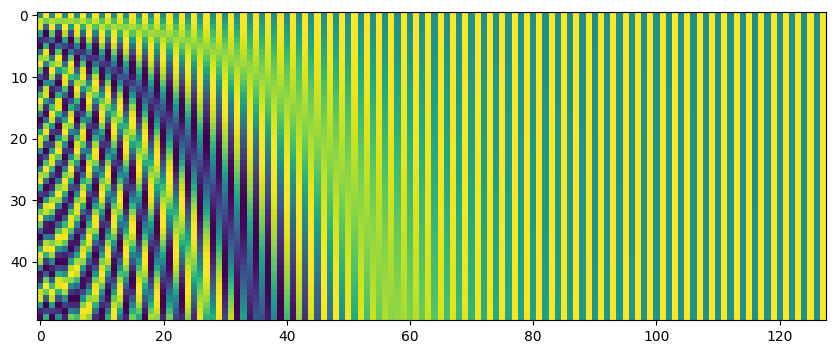

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

positional_enc = PositionalEncoding(128).to(device)
data = torch.zeros(1, 50, 128).to(device)
data_pos_enc = positional_enc.forward(data)

enc_np = data_pos_enc.squeeze(dim=0).to('cpu').numpy()
fig, ax = plt.subplots(figsize=(12, 4))
ax.imshow(enc_np)
plt.show()

## The Transformer model

Now combine all the pieces to build the Transformer model

In [ ]:

class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads, input_dict_size, output_dict_size):
        super().__init__()

        self.max_sent_len = 50

        self.input_emb = nn.Embedding(input_dict_size, d_model)
        self.outp_emb = nn.Embedding(output_dict_size, d_model)

        self.positional_encoder = PositionalEncoding(d_model)
        self.encoder = Encoder(num_layers, d_model, num_att_heads)
        self.decoder = Decoder(num_layers, d_model, num_att_heads)

        self.outp_logits = nn.Linear(d_model, output_dict_size)
        self.softmax = nn.Softmax(dim=2)

    def translate(self, src, tgt_start_code, tgt_eos_code, src_padding_mask, src_subsq_mask):

        # This function is already complete

        enc_x = self.input_emb.forward(src.squeeze(dim=2))
        enc_x = self.positional_encoder.forward(enc_x)
        enc_keys, enc_values = self.encoder.forward(enc_x, src_padding_mask, src_subsq_mask)

        snt = torch.ones((1,1,1)) * tgt_start_code
        snt = snt.long()
        snt = snt.to(device)

        translation_idxes = []

        for idx in range(self.max_sent_len):

            dec_x = self.outp_emb.forward(snt.squeeze(dim=2))
            dec_x = self.positional_encoder.forward(dec_x)
            dec_x = self.decoder.forward(
                dec_x,
                src_padding_mask = src_padding_mask,
                tgt_padding_mask = torch.zeros_like(snt).float().to(device),
                tgt_subsq_mask = get_square_subsequent_mask(snt.size()[1]),
                mem_keys = enc_keys,
                mem_values = enc_values
            )
            dec_x = self.outp_logits.forward(dec_x)
            dec_x = self.softmax(dec_x)
            next_word_softmax = dec_x[0,idx,:].to('cpu').detach()
            next_word_idx = torch.argmax(next_word_softmax)
            snt = torch.cat([snt, torch.ones((1,1,1)).long().to(device) * next_word_idx], dim=1)

            translation_idxes.append(next_word_idx)

            if next_word_idx == tgt_eos_code:
                break

        return translation_idxes


    def forward(self, src, tgt, src_padding_mask, src_subsq_mask, tgt_padding_mask, tgt_subsq_mask):

        enc_x = self.input_emb.forward(src.squeeze(dim=2))
        enc_x = self.positional_encoder.forward(enc_x)
        enc_keys, enc_values = self.encoder.forward(enc_x, src_padding_mask, src_subsq_mask)

        dec_x = self.outp_emb.forward(tgt.squeeze(dim=2))
        dec_x = self.positional_encoder.forward(dec_x)
        dec_x = self.decoder.forward(dec_x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, enc_keys, enc_values)
        dec_x = self.outp_logits.forward(dec_x)
        dec_x = self.softmax(dec_x)

        return dec_x

### Some helper functions

In [ ]:
def get_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len).to(device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def get_padding_mask(input, val1 = float('-inf'), val2 = float(0.0)):
    mask = torch.ones(input.size()).to(device)
    mask = mask.float().masked_fill(input == 0, val1).masked_fill(input > 0, val2)
    return mask


def get_one_hot(x, out_dim, mask):

    tens = x.view(-1)
    tens_one_hot = torch.zeros(list(tens.size()) + [out_dim]).to(device)
    for i in range(len(tens)):
        tens_one_hot[i,tens[i]] = 1

    tens_one_hot = tens_one_hot.view(list(x.size()) + [out_dim])
    tens_one_hot = tens_one_hot * mask
    return tens_one_hot.to(device)

In [ ]:
#Prepare the sentence for model translate function
def translate_sentences(src_sentences, tgt_sentences, max_sent_num = 15):

    transformer_model.eval()

    with torch.no_grad():

        for snt_idx in range(len(src_sentences)):

            if snt_idx > max_sent_num:
                break

            src = src_sentences[snt_idx:snt_idx+1]

            padded_src = pad_sequence(src, padding_value=0, batch_first=True).to(device)
            src_padding_mask = get_padding_mask(padded_src)
            src_subsq_mask = get_square_subsequent_mask(padded_src.size()[1])

            snt_translation = transformer_model.translate(
                src = padded_src,
                tgt_start_code = dataset.get_eng_start_code(),
                tgt_eos_code = dataset.get_eng_eos_code(),
                src_padding_mask = src_padding_mask,
                src_subsq_mask = src_subsq_mask
            )

            src_sent = ''
            for word_idx in src_sentences[snt_idx]:
                src_sent = f"{src_sent} {dataset.fra_token_to_text[word_idx]}"

            tgt_sent = ''
            for word_idx in tgt_sentences[snt_idx]:
                tgt_sent = f"{tgt_sent} {dataset.eng_token_to_text[word_idx]}"

            translated_sent = ''
            for word_idx in snt_translation:
                translated_sent = f"{translated_sent} {dataset.eng_token_to_text[word_idx]}"

            print(f"Source sentence is: {src_sent}")
            print(f"Target sentence is: {tgt_sent}")
            print(f"Model translation is: {translated_sent}")

    transformer_model.train()

### Hyperparams, model definition and dataset

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 2
STORE_MODELS = True
models_path = 'models'

if not os.path.exists(models_path):
    os.mkdir(models_path)

dataset = FraEngDataset()

sentences_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=fra_eng_dataset_collate)

in_dict_size = dataset.get_fra_dict_size()
out_dict_size = dataset.get_eng_dict_size()

transformer_model = Transformer(
    num_layers=6,
    d_model=512,
    num_att_heads=8,
    input_dict_size=in_dict_size,
    output_dict_size=out_dict_size
).to(device)

optimizer = torch.optim.Adam(transformer_model.parameters(), lr = 1e-4)


170190


# Training and sentence translation
Now just train the model. You should be able to see the translations at the end of each epoch. Check the quality of your translations. Be patient. Each epoch can take more than 2 hours in a GPU.

In [ ]:
for epoch in range(EPOCHS):

    src_sentences = None
    tgt_sentences = None

    train_loss_sum = 0.0
    total_word_count = 0.0

    for sentences in sentences_loader:

        src_sentences = sentences['fra_sentences']
        tgt_sentences = sentences['eng_sentences']

        tgt_sentences_out = []
        for idx in range(len(tgt_sentences)):
            tgt_sentences_out.append(tgt_sentences[idx][1:])
            tgt_sentences[idx] = tgt_sentences[idx][:-1]

        # Create tensors from token lists
        padded_src = pad_sequence(src_sentences, padding_value=0, batch_first=True).to(device)
        padded_tgt = pad_sequence(tgt_sentences, padding_value=0, batch_first=True).to(device)
        padded_tgt_out = pad_sequence(tgt_sentences_out, padding_value=0, batch_first=True).to(device)

        src_padding_mask = get_padding_mask(padded_src)
        src_subsq_mask = get_square_subsequent_mask(padded_src.size()[1])

        tgt_padding_mask = get_padding_mask(padded_tgt)
        tgt_subsq_mask = get_square_subsequent_mask(padded_tgt.size()[1])


        pred = transformer_model.forward(
            src=padded_src,
            tgt=padded_tgt,
            src_padding_mask=src_padding_mask,
            src_subsq_mask=src_subsq_mask,
            tgt_padding_mask=tgt_padding_mask,
            tgt_subsq_mask=tgt_subsq_mask
        )

        # Mask to zero one hot vectors corresponding to padded elements
        one_hot_mask = get_padding_mask(padded_tgt_out, val1=float(0.0), val2=float(1.0))
        y_one_hot = get_one_hot(padded_tgt_out.squeeze(dim=2), out_dict_size, mask=one_hot_mask)

        loss = - torch.sum(torch.log(pred) * y_one_hot)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss_sum += loss.detach().to('cpu').data
        total_word_count += torch.sum(y_one_hot).to('cpu').data

    print(f"Epoch {epoch} " + '=' * 60)
    print(f"Total loss per word: {train_loss_sum / total_word_count}")
    print(f"Some translated sentences:")
    with torch.no_grad():
     translate_sentences(src_sentences,tgt_sentences) # Take the last batch and translate some sentences.


    if STORE_MODELS == True:
        model_path = os.path.join(models_path, f'Epoch_{epoch}_model.pt')
        torch.save(transformer_model, model_path)

print("Training done! Generating some more sentences.")


Epoch 0 ============================================================
Total loss per word: 2.5541648864746094
Some translated sentences:
Source sentence is:  <START> Juste en la regardant , on peut voir qu'elle t'aime . <EOS>
Target sentence is:  <START> Just looking at her , you can tell that she likes you .
Model translation is:  I was in the world , but she can see you . <EOS>
Source sentence is:  <START> Tom m ' a dit qu'il n'avait pas peur de Marie . <EOS>
Target sentence is:  <START> Tom told me that he was n't afraid of Mary .
Model translation is:  Tom told me he was n't afraid of Mary . <EOS>
Source sentence is:  <START> Je ne peux me résoudre à faire une telle chose . <EOS>
Target sentence is:  <START> I ca n't bring myself to do such a thing .
Model translation is:  I ca n't solve myself to a thing . <EOS>
Source sentence is:  <START> Je ne pense pas que j'en ai une . <EOS>
Target sentence is:  <START> I do n't think I have one of those .
Model translation is:  I do n't think